In [1]:
from thymiodirect import Thymio, Connection
import time
import math
import ThymioUtils

In [2]:
port = Connection.serial_default_port()

In [3]:
# Connect to Thymio and store id in variable

th = Thymio(serial_port = port, on_connect = lambda id: print (f"{id} is connected"))
th.connect()
id_thymio = th.first_node()

34241 is connected


In [4]:
th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0
th[id_thymio]["leds.top"] = [0, 0, 0]

## Exercise 1




In [ ]:
th[id_thymio]["motor.left.target"] = 300
th[id_thymio]["motor.right.target"] = 300

time.sleep(20)

th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

## Exercise 2

#### Circle (Left Turn)

In [ ]:
# in mm
r = 200
# in mm per second
v = 90
v_inner, v_outer = ThymioUtils.curve_velocity(r, v)

th[id_thymio]["leds.top"] = [32, 0, 0]
th[id_thymio]["motor.left.target"] = v_inner
th[id_thymio]["motor.right.target"] = v_outer

time.sleep(ThymioUtils.time_for_circle(r, v))

th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

time.sleep(0.5)

#### Circle (Right Turn)

In [ ]:
th[id_thymio]["leds.top"] = [0, 32, 0]
th[id_thymio]["motor.left.target"] = v_outer
th[id_thymio]["motor.right.target"] = v_inner

time.sleep(ThymioUtils.time_for_circle(r, v))

th[id_thymio]["leds.top"] = [32, 32, 32]
th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

In [ ]:
# in mm
r = 200
# in mm per second
v = 90
v_inner, v_outer = ThymioUtils.curve_velocity(r, v)

th[id_thymio]["leds.top"] = [32, 0, 0]
th[id_thymio]["motor.left.target"] = v_inner
th[id_thymio]["motor.right.target"] = v_outer

time.sleep(ThymioUtils.time_for_circle(r, v))

th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

time.sleep(0.5)

th[id_thymio]["leds.top"] = [0, 32, 0]
th[id_thymio]["motor.left.target"] = v_outer
th[id_thymio]["motor.right.target"] = v_inner

time.sleep(ThymioUtils.time_for_circle(r, v))

th[id_thymio]["leds.top"] = [32, 32, 32]
th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

## Exercise 3

In [ ]:
# in mm
r = 200
# in mm per second
v = 90
v_thymio = ThymioUtils.mms_to_thymio(v)
v_inner, v_outer = ThymioUtils.curve_velocity(r, v)

## Three-quarter Circle (A - B)
th[id_thymio]["leds.top"] = [32, 0, 0]
th[id_thymio]["motor.left.target"] = v_inner
th[id_thymio]["motor.right.target"] = v_outer

time.sleep((ThymioUtils.time_for_circle(r, v, 270))

th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

time.sleep(0.5)

## Straight (B - C)
th[id_thymio]["leds.top"] = [32, 32, 0]
th[id_thymio]["motor.left.target"] = v_thymio
th[id_thymio]["motor.right.target"] = v_thymio

time.sleep(ThymioUtils.time_for_distance(2 * r, v))

th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

time.sleep(0.5)

## Three-quarter Circle (C - D) 
th[id_thymio]["leds.top"] = [32, 32, 0]
th[id_thymio]["motor.left.target"] = v_outer
th[id_thymio]["motor.right.target"] = v_inner

time.sleep((ThymioUtils.time_for_circle(r, v, 270))

th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

time.sleep(0.5)

## Straight (D - A)
th[id_thymio]["leds.top"] = [0, 0, 32]
th[id_thymio]["motor.left.target"] = v_thymio
th[id_thymio]["motor.right.target"] = v_thymio

time.sleep(ThymioUtils.time_for_distance(2 * r, v))

th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

## Exercise 4

## Exercise 8

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin
from ThymioUtils import *

In [6]:
def x(t):
    return 20*t

def y(t):
    return 0.8*((t-20)**2)+100

def c(t):
    x_coord = x(t)
    y_coord = y(t)
    return np.array([x_coord, y_coord])

def c1(t):
    h = 1E-8
    return (c(t+h)-c(t))/h

def c1_left(t):
    h = 0.01
    return (get_left_wheel(t+h)-get_left_wheel(t))/h

def c1_right(t):
    h = 0.01
    return (get_right_wheel(t+h)-get_right_wheel(t))/h

def rotate_vec_90(v):
    theta = np.deg2rad(90)

    rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return np.dot(rot, v)

def rotate_vec_270(v):
    theta = np.deg2rad(270)

    rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return np.dot(rot, v)

def get_left_wheel(t):
    x_value, y_value = c(t)
    x_left, y_left = rotate_vec_90(c1(t)/np.linalg.norm(c1(t)) * 48)
    return np.array([x_value + x_left, y_value + y_left])


def get_right_wheel(t):
    x_value, y_value = c(t)
    x_right, y_right = rotate_vec_270(c1(t)/np.linalg.norm(c1(t)) * 48)
    return np.array([x_value + x_right, y_value + y_right])

In [7]:
def plot_tangents(times):
    for time in times:
        if time == 20:
            print(c(time))
            print(c1(time))
        s1 = c(time)
        p1 = c1(time)
        ax.arrow(s1[0], s1[1], p1[0]*10, p1[1]*10)
        
def plot_tangents_left(times):
    for time in times:
        if time == 15:
            print(get_left_wheel(time))
            print(c1_left(time))
        s1 = get_left_wheel(time)
        p1 = c1_left(time)
        ax.arrow(s1[0], s1[1], p1[0], p1[1])

def plot_tangents_right(times):
    for time in times:
        if time == 15:
            print(get_right_wheel(time))
            print(c1_right(time))
        s1 = get_right_wheel(time)
        p1 = c1_right(time)
        ax.arrow(s1[0], s1[1], p1[0], p1[1])
        
def plot_tangents_rotated(times):
    for time in times:
        s1 = c(time)
        p1 = rotate_vec_90(c1(time)/np.linalg.norm(c1(time)) * 48)
        p2 = rotate_vec_270(c1(time)/np.linalg.norm(c1(time)) * 48)
        ax.arrow(s1[0], s1[1], p1[0], p1[1])
        ax.arrow(s1[0], s1[1], p2[0], p2[1])

[317.82675028 164.56688204]
[16.92515068 -6.76329056]
[282.17324972  75.43311796]
[23.07484932 -9.22070944]


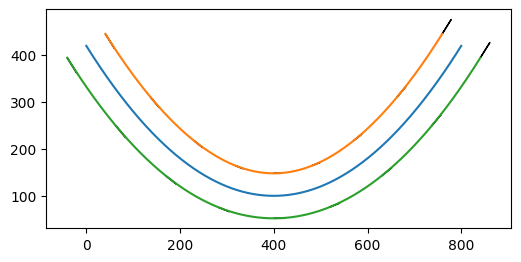

In [8]:
x_values = []
y_values = []
x_lefts = []
y_lefts = []
x_rights = []
y_rights = []

for i in range(2001):
    t = i/50
    x_value, y_value = c(t)
    x_left, y_left = rotate_vec_90(c1(t)/np.linalg.norm(c1(t)) * 48)
    x_right, y_right = rotate_vec_270(c1(t)/np.linalg.norm(c1(t)) * 48)
    x_values.append(x_value)
    y_values.append(y_value)
    x_lefts.append(x_value + x_left)
    y_lefts.append(y_value + y_left)
    x_rights.append(x_value + x_right)
    y_rights.append(y_value + y_right)
    
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', 'box')
    
ax.plot(x_values, y_values)
ax.plot(x_lefts, y_lefts)
ax.plot(x_rights, y_rights)
plot_tangents_left([0, 5, 10, 15, 20, 25, 30, 35, 40])
plot_tangents_right([0, 5, 10, 15, 20, 25, 30, 35, 40])
#plot_tangents([0, 5, 10, 15, 20, 25, 30, 35, 40])
#plot_tangents_rotated([0, 5, 10, 15, 20, 25, 30, 35, 40])

In [9]:
times = []
left_speeds = []
right_speeds = []

for i in range(400):
    t = i/10
    times.append(t)
    left_speeds.append(mms_to_thymio(np.linalg.norm(c1_left(t))))
    right_speeds.append(mms_to_thymio(np.linalg.norm(c1_right(t))))


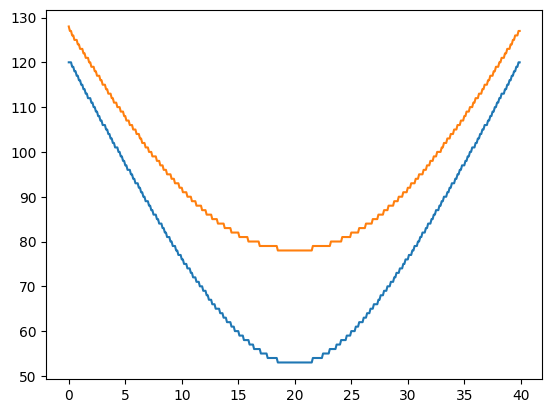

In [10]:
plt.plot(times, left_speeds)
plt.plot(times, right_speeds)

In [11]:
for speed in zip(left_speeds, right_speeds):
    th[id_thymio]["motor.left.target"] = speed[0]
    th[id_thymio]["motor.right.target"] = speed[1]
    time.sleep(0.1)
    
th[id_thymio]["motor.left.target"] = 0
th[id_thymio]["motor.right.target"] = 0

In [ ]:
def c1_right(t):
    h = 0.00001
    print(get_right_wheel(t+h))
    print(get_right_wheel(t))
    return (get_right_wheel(t+h)-get_right_wheel(t))/h

c1_right(15)

In [ ]:
rotate_vec(tangent_20)

In [ ]:
x_values = []
y_values = []
x_tangs = []
y_tangs = []

for i in range(1900, 2100):
    t = i/100
    x_value, y_value = c(t)
    x_values.append(x_value)
    y_values.append(y_value)
    
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
    
ax.plot(x_values, y_values)
plot_tangents([20])
plot_tangents_rotated([20])

In [ ]:
c1(20)

## Appendix


In [ ]:
def mms_to_thymio(v):
    v_thymio = v * 3.3
    return min(math.floor(v_thymio), 400)

def curve_velocity(r, v):
    w = v / r
    v_inner = w * (r - 105/2)
    v_outer = w * (r + 105/2)
    return mms_to_thymio(v_inner), mms_to_thymio(v_outer)

def time_for_distance(d, v):
    return d / v;

def time_for_circle(r, v):
    return time_for_distance(2 * r * math.pi, v);